# Numerov Calculation Script

In [1]:
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt
import math

/home/lme/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Data Read-In

We need the scan file with the dipole moment and we need our numerov.dat file

In [94]:
df = pd.read_csv("f_2/numerov.dat", skiprows = 2, names = ["Distances","Energies","Wf_shifted_0","Wf_shifted_1","Wf_shifted_2","Wf_shifted_3","Wf_shifted_4","Wf_0","Wf_1","Wf_2","Wf_3","Wf_4"], sep="\s+")

eigenvalues = pd.read_csv("f_2/numerov.dat", skiprows=1, nrows=1, sep="\s+",names=["a","b","c","d","e","f"])

scan_dat = pd.read_csv("f_2/scan_data.dat",sep="\t",names=["Distances", "Energy", "Dipole_vectors_xyz"])

dipole_vectors = scan_dat.loc[:, "Dipole_vectors_xyz"]

# This splits the individual dipole vectors
dipole_vectors_split = dipole_vectors.str.split(r'\s+',expand=True)
dipole_vectors_split = dipole_vectors_split.astype(float)

print(dipole_vectors_split)

       0    1    2
0   -0.0  0.0  0.0
1   -0.0 -0.0  0.0
2    0.0  0.0 -0.0
3    0.0  0.0 -0.0
4   -0.0 -0.0 -0.0
..   ...  ...  ...
146  0.0  0.0  0.0
147 -0.0 -0.0  0.0
148 -0.0 -0.0  0.0
149 -0.0 -0.0 -0.0
150  0.0 -0.0  0.0

[151 rows x 3 columns]


In [ ]:
eigenvalues_numpy = eigenvalues.to_numpy()
eigenvalues_slices = eigenvalues_numpy[0,1:]




# Next of we calculate v_n0

eigenvalue_0 = eigenvalues_slices[0]
print("eigenvalue_0:", eigenvalue_0)


# Now we iterate and calculate all our v_n0s

v_n0 = []
for i, eig in enumerate(eigenvalues_slices):
    if i == 0:
        continue
    else:
        v_n0.append((eig - eigenvalue_0)/const.h * 6.9477e-21) 

# we have to turn this into a wavenumber ws

c = const.speed_of_light * 100 # in cm/s

v_n = []   #v_n in cm^-1
for freq in v_n0:
    v_n.append(freq / c)


    
# Select all x,y,z values for our dipole moment

mu_x = dipole_vectors_split.loc[:, 0]
mu_y = dipole_vectors_split.loc[:, 1]
mu_z = dipole_vectors_split.loc[:, 2]



# And get the bond distances

distances = df.loc[:, "Distances"]



# Select the Wave_Functions for the y_0 and y_n --> as there are just 4 we can do this manually

wf_0 = df.loc[:, "Wf_0"]
wf_1 = df.loc[:, "Wf_1"]
wf_2 = df.loc[:, "Wf_2"]
wf_3 = df.loc[:, "Wf_3"]
wf_4 = df.loc[:, "Wf_4"]


# Make a integrand function

def calculate_integrand(wf_0,mu_comp,wf_n):
    return np.array(wf_0 * mu_comp*wf_n)

integral_mu_x = []
integral_mu_y = []
integral_mu_z = []

for i in range(1,5):
    wf_0 = df.loc[:, "Wf_0"]
    wf_n = df.loc[:, f"Wf_{i}"]
    integral_mu_x.append(np.trapz(calculate_integrand(wf_0,mu_x,wf_n),distances))
    integral_mu_y.append(np.trapz(calculate_integrand(wf_0,mu_y,wf_n),distances))
    integral_mu_z.append(np.trapz(calculate_integrand(wf_0,mu_z,wf_n),distances))



    
        
# Now we can calculate the transition dipole moment for n=1-4

mu_n_squared = []
mu_n=[]
mu_x2=[]
mu_y2=[]
mu_z2=[]
for i, item in enumerate(integral_mu_x):
    mu_n_squared.append(abs(integral_mu_x[i])**2 + abs(integral_mu_y[i])**2 + abs(integral_mu_z[i])**2)
    mu_n.append(math.sqrt(abs(integral_mu_x[i])**2 + abs(integral_mu_y[i])**2 + abs(integral_mu_z[i])**2))
    mu_x2.append(abs(integral_mu_x[i]))
    mu_y2.append(abs(integral_mu_y[i]))
    mu_z2.append(abs(integral_mu_z[i]))
print("mu_n_squared:", mu_n_squared)

f_n0 = []
for i in range(4):
    f_n0.append((4.702e-7)*mu_n_squared[i]*v_n[i])

print("f_n0:",f_n0)





        


eigenvalue_0: 1.484791735342
1
2
3
4
mu_n_squared: [0.0, 0.0, 0.0, 0.0]
f_n0: [0.0, 0.0, 0.0, 0.0]


In [190]:
w_0 = df.loc[:, "Wf_0"]
w_1 = df.loc[:, "Wf_1"]
w_2 = df.loc[:, "Wf_2"]
w_3 = df.loc[:, "Wf_3"]
w_4 = df.loc[:, "Wf_4"]

row1,row2,row3,row4,row5 = [],[],[],[],[]



for i in range(5):
    w_select = df.loc[:, f"Wf_{i}"]
    row1.append(np.trapz(w_0 * w_select, distances))
    row2.append(np.trapz(w_1 * w_select, distances))
    row3.append(np.trapz(w_2 * w_select, distances))
    row4.append(np.trapz(w_3 * w_select, distances))
    row5.append(np.trapz(w_4 * w_select, distances))

row1 = pd.DataFrame(row1)
row2 = pd.DataFrame(row2)
row3 = pd.DataFrame(row3)
row4 = pd.DataFrame(row4)
row5 = pd.DataFrame(row5)

stacked_rows = pd.concat([row1,row2,row3,row4,row5],axis=1)

i,j = np.indices(stacked_rows.shape)







print(stacked_rows)

              0             0             0             0             0
0  1.000000e+00 -6.090009e-15 -2.376750e-14  3.414086e-14  4.831405e-14
1 -6.090009e-15  1.000000e+00 -4.677598e-14  2.072957e-14 -4.191959e-15
2 -2.376750e-14 -4.677598e-14  1.000000e+00  3.332686e-14  2.571467e-14
3  3.414086e-14  2.072957e-14  3.332686e-14  1.000000e+00  2.124863e-14
4  4.831405e-14 -4.191959e-15  2.571467e-14  2.124863e-14  1.000000e+00


In [191]:
print(c)
print(len(integral_mu_x))
print(len(mu_x2))
print(v_n)
print(mu_n_squared)

29979245800.0
4
4
[1027.6955390120186, 2041.1492257160342, 3040.467548937814, 4025.7747535683666]
[0.0, 0.0, 0.0, 0.0]


In [192]:
g=open("LiH_numerov_calc_output.dat", "a")
print("mu_n_squared:", mu_n_squared, file=g)
print("f_n0:",f_n0, file=g)
g.close()



### Harmonic

In [193]:
data=pd.read_csv("f_2/scan_data.dat", sep="\s+", names=["Distance", "Energy", "x","y", "z"])

In [194]:
energy=df["Energies"]
energy_list=(list(energy))
e_min=min(energy)
print(e_min)
index_emin=energy_list.index(e_min)
print(energy)

0.0
0      368.179382
1      343.257357
2      319.848424
3      297.862748
4      277.216007
          ...    
146     82.515739
147     83.130814
148     83.736964
149     84.334262
150     84.922788
Name: Energies, Length: 151, dtype: float64


In [195]:
print(energy[index_emin-1])

0.04465043847449


In [196]:
k=((energy[index_emin-1]-2*e_min+energy[index_emin+1])/((0.01)**2))
print(k)

874.9427710426999


In [197]:
y=data["Energy"]
y_list=list(y)
x=data["Distance"]
x0=x[y_list.index(min(y))]
harmonic=0.5*k*(x-x0)**2
print(harmonic)

0      109.367846
1      105.036880
2      100.793407
3       96.637429
4       92.568945
          ...    
146    403.173629
147    411.616827
148    420.147519
149    428.765705
150    437.471386
Name: Distance, Length: 151, dtype: float64


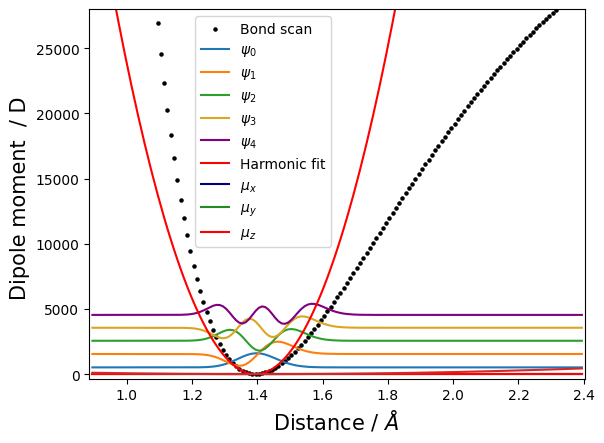

In [198]:
plt.plot(x, harmonic)
plt.show()

### Plotting

In [199]:
x=df["Distances"]
y_1=df["Energies"]

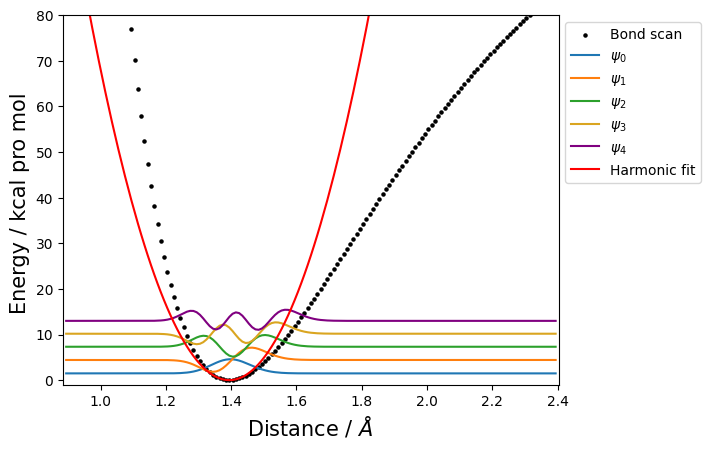

In [200]:
plt.scatter(x,y_1, s=5, c="black", label="Bond scan")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Energy / kcal pro mol ", size=15)
#plt.title("Bond Scan of LiH", size =20)
plt.plot(x, df['Wf_shifted_0'], label=r"$\psi_0$")
plt.plot(x, df['Wf_shifted_1'], label=r"$\psi_1$")
plt.plot(x, df['Wf_shifted_2'], label=r"$\psi_2$")
plt.plot(x, df['Wf_shifted_3'], label=r"$\psi_3$", c='goldenrod')
plt.plot(x, df['Wf_shifted_4'], label=r"$\psi_4$", c='purple')
plt.plot(x,harmonic,c="red", label="Harmonic fit")
plt.ylim(-1, 80)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
plt.legend(loc="upper right", bbox_to_anchor=[0.3, 0, 1, 1])

plt.show()

#plt.savefig("Bond_scan_trans_formic_H_numerov.png", dpi=700, bbox_inches="tight")

In [201]:
energy_cm=df['Energies']*349.757
wf_cm0=df["Wf_shifted_0"]*349.757
wf_cm1=df["Wf_shifted_1"]*349.757
wf_cm2=df["Wf_shifted_2"]*349.757
wf_cm3=df["Wf_shifted_3"]*349.757
wf_cm4=df["Wf_shifted_4"]*349.757
harmonic_cm=harmonic*349.757

In [202]:
plt.scatter(x,energy_cm, s=5, c="black", label="Bond scan")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Energy / $cm^{-1}$ ", size=15)
#plt.title("Bond Scan of LiH", size =20)
plt.plot(x, wf_cm0, label=r"$\psi_0$")
plt.plot(x, wf_cm1, label=r"$\psi_1$")
plt.plot(x, wf_cm2, label=r"$\psi_2$")
plt.plot(x, wf_cm3, label=r"$\psi_3$", c="goldenrod")
plt.plot(x, wf_cm4, label=r"$\psi_4$", c="purple")
plt.plot(x,harmonic_cm,c="red", label="Harmonic fit")
plt.legend(loc="upper right", bbox_to_anchor=[0.3, 0, 1, 1])
plt.ylim(-350, 28000)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
#plt.savefig("Bond_scan_trans_formic_H_numerov_cm.png", dpi=700, bbox_inches="tight")

(0.88426, 2.40426)

### Dipolemoment

In [203]:
#plt.plot(x, mu_n, label=r"$\mu$")
plt.plot(x, mu_x, label=r"$\mu_{x}$", c="navy")
plt.plot(x, mu_y, label=r"$\mu_{y}$", c="forestgreen")
plt.plot(x, mu_z, label=r"$\mu_{z}$", c="red")
plt.legend(bbox_to_anchor=[0.2, 0, 1, 1])
plt.xlabel("Distance")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Dipole moment  / D ", size=15)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
#plt.savefig("Dipolemoment_trans_formic_H.png", dpi=700, bbox_inches="tight")

(0.88426, 2.40426)